In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path

import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

import tensorflow as tf
from tensorflow.keras import layers, regularizers, optimizers

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Add, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0

2023-08-10 14:48:17.695860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 14:48:17.747143: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 14:48:17.747964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 14:48:18.500416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)

zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

all_nan_dates = np.isnan(zarr_new["sst"]).all(dim=["lon", "lat"]).compute()

zarr_ds = zarr_new.sel(time=all_nan_dates == False)

zarr_ds = zarr_ds.sortby('time')
zarr_ds = zarr_ds.sel(time=slice('2010-01-01', '2022-12-31'))

In [3]:
import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

def preprocess_day_data(day_data):
    day_data = da.squeeze(day_data)
    mean_val = da.nanmean(day_data).compute()  # compute here to get scalar value
    return day_data - mean_val

def preprocess_data(zarr_ds, chunk_size=200):
    total_len = zarr_ds['sst'].shape[0]
    chunk_shape = (chunk_size,) + zarr_ds['sst'].shape[1:]  # Adjusted chunking
    chunks = []

    for start_idx in range(0, total_len, chunk_size):
        end_idx = min(start_idx + chunk_size, total_len)
        
        # Directly slice the dask array without wrapping it with da.from_array again
        chunk = zarr_ds['sst'][start_idx:end_idx]
        
        processed_chunk = chunk.map_blocks(preprocess_day_data)
        
        # Use da.where to replace NaNs with 0.0
        processed_chunk = da.where(da.isnan(processed_chunk), 0.0, processed_chunk)
        
        chunks.append(processed_chunk)

    return da.concatenate(chunks, axis=0)

processed_data = preprocess_data(zarr_ds).compute()

def prepare_data_from_processed(processed_data, window_size=5): 
    length = processed_data.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(processed_data[i:i+window_size])
        y.append(processed_data[i+window_size])

    X, y = da.array(X), da.array(y)
    return X, y

X, y = prepare_data_from_processed(processed_data)

In [4]:
def time_series_split(X, y, train_ratio=0.7, val_ratio=0.2):
    total_length = X.shape[0]
    
    # Compute end indices for each split
    train_end = int(total_length * train_ratio)
    val_end = int(total_length * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y)

In [5]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_size, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        if embed_size % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_size} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_size // num_heads
        self.query_dense = Dense(embed_size)
        self.key_dense = Dense(embed_size)
        self.value_dense = Dense(embed_size)
        self.combine_heads = Dense(embed_size)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_size))
        output = self.combine_heads(concat_attention)
        return output


In [7]:
from tensorflow.keras.layers import Input, Masking, TimeDistributed, GlobalAveragePooling1D, Dense, Reshape, Conv2DTranspose, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

from tensorflow.keras.layers import Input, Masking, TimeDistributed, GlobalAveragePooling1D, Dense, Reshape, Conv2DTranspose, BatchNormalization, Add, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

from keras.layers import Lambda

def build_model(input_shape=(5, 149, 181, 1), num_heads=4, dropout_rate=0.1, regularizer=tf.keras.regularizers.l2(0.001)):
    inputs = Input(shape=input_shape)
    
    # Using EfficientNet without top layers and without pooling
    base_model = EfficientNetB0(include_top=False, weights=None, pooling=None)
    efficientnet = TimeDistributed(base_model)(inputs)
    
    # Get the shape of the expected skip layer output 
    skip_shape = base_model.get_layer(name="block7a_expand_conv").output_shape[1:]
    
    # Since it's time-distributed, we need to insert the time dimension at the beginning
    td_skip_shape = (input_shape[0],) + skip_shape
    
    # Get the output for the skip connection without reshaping
    skip_layer = TimeDistributed(Conv2D(64, (1, 1), activation="relu"))(efficientnet)
    
    # I assume you have already defined the MultiHeadSelfAttention before
    transformer_block = MultiHeadSelfAttention(embed_size=efficientnet.shape[-1], num_heads=num_heads)
    x = transformer_block(efficientnet)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(149 * 181)(x)
    x = Reshape((149, 181, 1))(x)

    x = Conv2DTranspose(64, (3,3), strides=(1,1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Add()([x, skip_layer])  # Skip connection
    
    x = Conv2DTranspose(32, (3,3), strides=(1,1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(16, (3,3), strides=(1,1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(1, (3,3), strides=(1,1), padding='same')(x)
    
    outputs = x
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_model(input_shape=(5, 149, 181, 1))


ValueError: Inputs have incompatible shapes. Received shapes (5, 4, 5, 64) and (149, 181, 64)

In [ ]:
model.summary()

In [7]:
# from tensorflow.image import ssim
# from tensorflow import reduce_mean

# def SSIMLoss(y_true, y_pred):
#     return 1 - reduce_mean(ssim(y_true, y_pred, max_val=1.0))

In [10]:
# model.compile(optimizer='adam', loss=SSIMLoss, metrics=['mae'])
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

history = model.fit(train_dataset, epochs=40, validation_data=val_dataset, callbacks=[early_stop])

Epoch 1/40
101/101 [==============================] - 297s 3s/step - loss: 0.5791 - mse: 0.5791 - val_loss: 1.6706 - val_mse: 1.6706
Epoch 2/40
101/101 [==============================] - 275s 3s/step - loss: 0.2536 - mse: 0.2536 - val_loss: 1.3389 - val_mse: 1.3389
Epoch 3/40
101/101 [==============================] - 273s 3s/step - loss: 0.2164 - mse: 0.2164 - val_loss: 0.4350 - val_mse: 0.4350
Epoch 4/40
101/101 [==============================] - 273s 3s/step - loss: 0.1965 - mse: 0.1965 - val_loss: 0.2459 - val_mse: 0.2459
Epoch 5/40
101/101 [==============================] - 275s 3s/step - loss: 0.1829 - mse: 0.1829 - val_loss: 0.4120 - val_mse: 0.4120
Epoch 6/40
101/101 [==============================] - 273s 3s/step - loss: 0.1805 - mse: 0.1805 - val_loss: 0.2366 - val_mse: 0.2366
Epoch 7/40
101/101 [==============================] - 273s 3s/step - loss: 0.1712 - mse: 0.1712 - val_loss: 0.2394 - val_mse: 0.2394
Epoch 8/40
101/101 [==============================] - 273s 3s/step - 

In [11]:
def preprocess_vis_input_data(day_data):
    day_data = np.squeeze(day_data)
    mean_val = np.nanmean(day_data)
    processed_data = day_data - mean_val
    # Replace NaNs with 0.0
    processed_data = np.where(np.isnan(processed_data), 0.0, processed_data)
    return processed_data

def postprocess_prediction(prediction, input_data):
    # Find positions where the last day of input_data is 0
    land_mask = np.load('land_mask.npy')
    # Set those positions in the prediction to NaN
    prediction[land_mask] = np.nan
    
    # Add back the historical mean
    mean_val = np.nanmean(input_data)
    prediction = np.where(np.isnan(prediction), np.nan, prediction + mean_val)
    
    return prediction

def predict_and_plot(date_to_predict, window_size, model, dataset, plot=True):
    # Step 1: Select the time window
    time_index = np.where(dataset['time'].values == np.datetime64(date_to_predict))[0][0]
    input_data_raw = dataset['sst'][time_index-window_size:time_index].values
    true_output_raw = dataset['sst'][time_index].values

    # Preprocess the input data
    input_data = np.array([preprocess_vis_input_data(day) for day in input_data_raw])
    
    # Step 2: Make prediction
    prediction = model.predict(input_data[np.newaxis, ...])[0]
    
    # Postprocess the prediction
    prediction_postprocessed = postprocess_prediction(prediction, input_data_raw)
    
    # Step 3: Visualize
    if plot:
        # Determine common scale for all plots
        input_data_raw = input_data_raw[..., np.newaxis]
        true_output_raw = true_output_raw[np.newaxis, ..., np.newaxis]
        prediction_postprocessed = prediction_postprocessed[np.newaxis, ...]
        
        all_data = np.concatenate([input_data_raw, prediction_postprocessed, true_output_raw])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)
        
        def plot_sample(sample, title=''):
            sample_2d = np.squeeze(sample)
            plt.imshow(sample_2d, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.title(title)
            plt.colorbar()
            plt.show()

        # show input frames
        for i, frame in enumerate(input_data_raw):
            plot_sample(frame, title=f'Input Frame {i+1} ({dataset["time"].values[time_index-window_size+i]})')
        
        # show predicted output
        plot_sample(prediction_postprocessed, title=f'Predicted Output ({date_to_predict})')
        
        # show true output
        plot_sample(true_output_raw, title=f'True Output ({date_to_predict})')

    return input_data_raw, prediction_postprocessed, true_output_raw

In [12]:
def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

1/1 [==============================] - 2s 2s/step


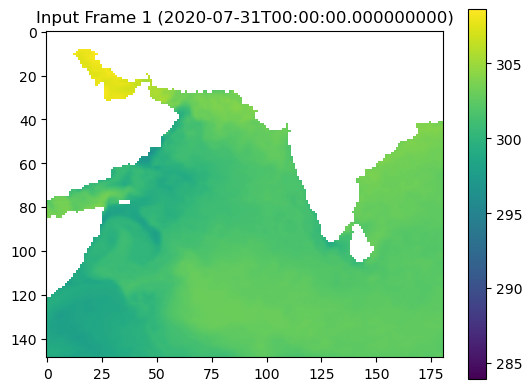

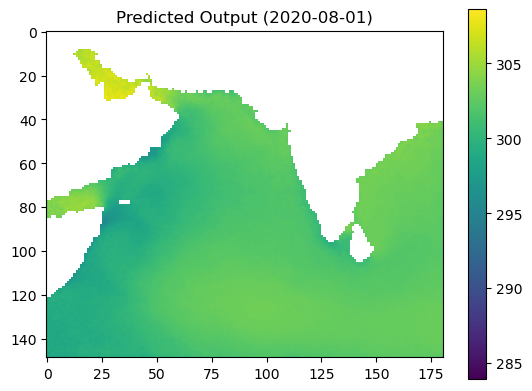

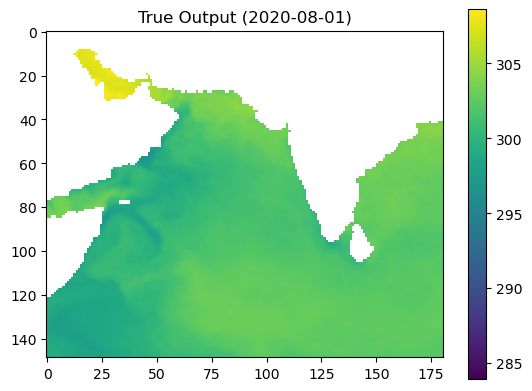

MAE between Predicted Output and True Output: 0.4379304051399231
MAE between Last Input Frame and True Output: 0.143082395195961


In [13]:
date_to_predict = '2020-08-01'
window_size = 1
input_data, predicted_output, true_output = predict_and_plot(date_to_predict, window_size, model, zarr_ds)

predicted_mae = compute_mae(true_output, predicted_output)
print(f"MAE between Predicted Output and True Output: {predicted_mae}")

last_input_frame = input_data[-1]
last_input_frame_2d = np.squeeze(last_input_frame)
true_output_2d = np.squeeze(true_output)
last_frame_mae = compute_mae(true_output_2d, last_input_frame_2d)
print(f"MAE between Last Input Frame and True Output: {last_frame_mae}")

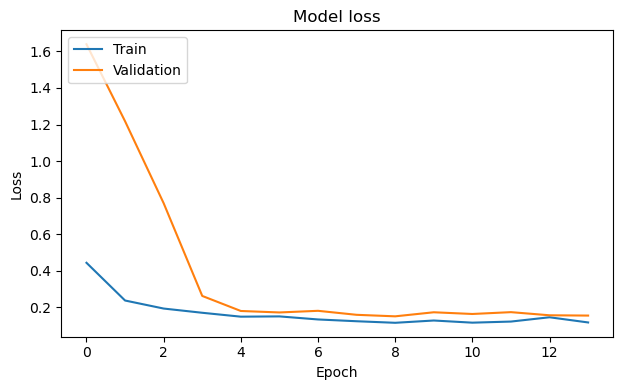

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values (only if 'accuracy' is in the history keys)
if 'mae' in history.history.keys():
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [27]:
np.nanmean(input_data[-1])

301.71075